# SV Live Demo

In [5]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import pandas as pd
import os
import itertools

## Speaker Verification

### Model Load

In [8]:
from demo_ResNet34 import ResNet34, ResNet34_v1
from demo_tdnnModel import tdnn_xvector, tdnn_xvector_v1

config = dict(
    loss="softmax",
    gpu_no=[0], no_cuda=True,
    input_dim=40
)

In [9]:
# model = ResNet34(config, inplanes=16, n_labels=1759)
# model = ResNet34_v4(config, layers=[3,4,6,3], n_labels=1260)
# model = tdnn_xvector_v1(config, n_labels=1759)
model = ResNet34_v1(config, n_labels=1759)

In [10]:
model.load_extractor("model_best.pth.tar")
model.eval()

if not config['no_cuda']:
    model.cuda()

extractor loaded from model_best.pth.tar


In [59]:
torch.load("model_best.pth.tar")["best_metric"]

0.09366666666666666

###  Speaker Verification System

In [228]:
import librosa
# from pydub import AudioSegment
from demo_manage_audio import strip_audio
from demo_manage_audio import preprocess_audio
import numpy as np
import torch
import torch.nn.functional as F
import pickle
from sklearn import preprocessing, cluster

def seg2wav(seg):
    wav_data = (np.array(seg.get_array_of_samples())
                / 32768.0).astype(np.float32)
    
    return wav_data

def zero_padding(data, in_len):
    padding_len = max(0, in_len - len(data))
    data = np.pad(data, (padding_len//2, padding_len - padding_len//2), "constant")
    
    return data

class sv_system():
    def __init__(self, model, spk_models=None, lda_model=None,
                 n_dims=40, feat_format='fbank'):
        self.lda_model = pickle.load(open(lda_model, "rb")) if lda_model \
                                else None
        self.dct_filters = librosa.filters.dct(n_filters=n_dims, n_input=n_dims)
        self.model = model
        self.n_dims = n_dims
        self.feat_format = feat_format
        self.enrolled_feats = dict()
        self.enrolled_dvectors = dict()
        self.speaker_models =  pickle.load(open(spk_models, "rb")) if spk_models \
                                else None
    
    def enrol(self, wav, spk_name):
        feat = self._wav2feat(wav)
#         print("feat shape: {}".format(feat.shape))
        dvector = self._extract_dvector(feat).squeeze()
        if spk_name not in self.enrolled_dvectors:
            self.enrolled_feats[spk_name] = [feat]
            self.enrolled_dvectors[spk_name] = [dvector]
        else:
            self.enrolled_feats[spk_name] += [feat]
            self.enrolled_dvectors[spk_name] += [dvector]
            
        
    def enrols(self, wav, spk_name):
        feats = self._wav2feats(wav)
        for feat in feats:
            dvector = self._extract_dvector(feat).squeeze()

            if spk_name not in self.enrolled_dvectors:
                self.enrolled_dvectors[spk_name] = [dvector]
            else:
                self.enrolled_dvectors[spk_name] += [dvector]
                   
    def _extract_dvector(self, feat):
        """
            dvector: ndarray
        """
        if feat.dim() == 2:
            feat = feat.unsqueeze(0).unsqueeze(0)
        elif feat.dim() == 3:
            if isinstance(self.model, ResNet34_v1):
                feat = feat.unsqueeze(1)
            else:
                feat = feat.unsqueeze(0)
                
        
        dvector = self.model.embed(feat).detach().cpu().numpy()
        if self.lda_model:
            dvector = self.lda_model.transform(dvector).astype(np.float32)
                
        return dvector
    
    def _wav2feats(self, wav):
        wav_seg = AudioSegment.from_wav(wav)
#         wav_seg = wav_seg.normalize()
        voice_segs = pydub.silence.split_on_silence(wav_seg, min_silence_len=100, 
                keep_silence=500, silence_thresh=-32)
        self.voice_segs = voice_segs
        print([len(seg) for seg in voice_segs])
#         max_len = int(len(max(voice_segs, key=len)) * 16000/1000)
#         wav_data = [zero_padding(strip_audio(seg2wav(seg), rms_ths=0.10), 16000)
#                     for seg in voice_segs]
        wav_data = [seg2wav(seg) for seg in voice_segs]
        feats = []
        for wav_d in wav_data:
            feat = preprocess_audio(wav_d, n_mels=self.n_dims, 
                        dct_filters=self.dct_filters, in_feature=self.feat_format)
            feats.append(feat)
        
        return feats
        
    def _wav2feat(self, wav):
        """
            extracting input feature from wav (mfcc, fbank)
        """
        wav_data = librosa.core.load(wav, sr=16000)[0]
#         wav_seg = AudioSegment.from_wav(wav)
#         wav_seg = wav_seg.normalize()
#         print(len(wav_seg))
#         wav_seg = wav_seg.strip_silence(silence_len=200, padding=200, silence_thresh=-32)
#         assert len(wav_seg) > 0, "no voice"
#         wav_data = seg2wav(wav_seg)
#         wav_data = strip_audio(wav_data, rms_ths=0.10)
#         wav_data = zero_padding(wav_data, 16000)
        
        feat = preprocess_audio(wav_data, n_mels=self.n_dims, 
                    dct_filters=self.dct_filters, in_feature=self.feat_format)
        
        return feat
    
    def _wav2dvector(self, wav):
        feat = self._wav2feat(wav)
        dvector = self._extract_dvector(feat)
        
        return dvector
        
    def init_enrollemnt(self):
        self.enrolled_feats = dict()
        self.enrolled_dvectors = dict()
    
    def compute_spk_model(self, spk_model_type="avg"):
        self.spk_model_type = spk_model_type
        if spk_model_type == "avg":
            self.speaker_models = np.stack([np.mean(v, axis=0).squeeze() 
                                            for v in self.enrolled_dvectors.values()], 
                                            axis=0)
        elif spk_model_type == "concat":
            self.speaker_models = np.concatenate([self._extract_dvector(torch.cat(v, dim=0)) 
                                            for v in self.enrolled_feats.values()], 
                                              axis=0)
        elif spk_model_type == "cluster":
            self.speaker_models = dict()
            for k, v in self.enrolled_dvectors.items():
                v = np.array(v)
#                 v_norm = preprocessing.normalize(v)
                v_norm = v
                cluster_ids = cluster.KMeans(3).fit_predict(v_norm)
                speaker_model = []
                for id_ in range(3):
                     speaker_model += [np.mean(v[np.where(cluster_ids == id_)], axis=0)]
                self.speaker_models[k] = np.array(speaker_model)

            
    def verify_from_dvectors(self, dvectors):
        scores = []
        pred_speakers = []
        for test_dvector in dvectors:
            if self.spk_model_type in ['avg', 'concat']:
                score = F.cosine_similarity(torch.from_numpy(self.speaker_models).float(), 
                                                torch.from_numpy(test_dvector).float(), dim=1).numpy()
            elif self.spk_model_type in ['median', 'mean']:            
                score = []
                for k, v in self.enrolled_dvectors.items():
                    v = np.array(v)
                    score_ = F.cosine_similarity(torch.from_numpy(v).float(), 
                                                torch.from_numpy(test_dvector).float(), dim=1).numpy()
                    if self.spk_model_type == 'median':
                        score.append(np.median(score_))
                    else:
                        score.append(np.mean(score_))
            elif self.spk_model_type in ['cluster']:
                score = []
                for k, v in self.speaker_models.items():
                    score_ = F.cosine_similarity(torch.from_numpy(v).float(),
                                                torch.from_numpy(test_dvector).float(), dim=1).numpy()
                    score.append(max(score_))


            pred_speaker = list(self.enrolled_dvectors.keys())[np.argmax(score)]
            
            scores.append(score)
            pred_speakers.append(pred_speaker)
            
        return pred_speakers, scores

    def verify(self, wav):
        """
            verify a input wav and output a verification result
            and rank-1 identification
        """
        feat = self._wav2feat(wav)
        test_dvector = self._extract_dvector(feat)
        if self.spk_model_type in ['avg', 'concat']:
            score = F.cosine_similarity(torch.from_numpy(self.speaker_models).float(), 
                                            torch.from_numpy(test_dvector).float(), dim=1).numpy()
        elif self.spk_model_type in ['median', 'mean']:            
            score = []
            for k, v in self.enrolled_dvectors.items():
                v = np.array(v)
                score_ = F.cosine_similarity(torch.from_numpy(v).float(), 
                                            torch.from_numpy(test_dvector).float(), dim=1).numpy()
                if self.spk_model_type == 'median':
                    score.append(np.median(score_))
                else:
                    score.append(np.mean(score_))
        elif self.spk_model_type in ['cluster']:
            score = []
            for k, v in self.speaker_models.items():
                score_ = F.cosine_similarity(torch.from_numpy(v).float(),
                                            torch.from_numpy(test_dvector).float(), dim=1).numpy()
                score.append(max(score_))
                    
        pred_speaker = list(self.enrolled_dvectors.keys())[np.argmax(score)]
            
        return pred_speaker, score

### parse dataset 

In [205]:
kor_dataset = os.listdir("../dataset/kor_commands/wav/")

In [206]:
records = []
for wav_file in kor_dataset:
    filen = wav_file.rstrip('.wav')
    spk, sent = filen.split('_')[0], filen.split('_')[1]
    records.append((spk, sent, "../dataset/kor_commands/wav/"+wav_file))

In [207]:
kor_dataset_df = pd.DataFrame.from_records(records, columns=['spk', 'sent', 'wav'])

### Enrollment

In [208]:
blacklist = ['hm', 'hs', 'be', 'ms', 'ds', 'cy', 'dw', 'dg', 'ej']
blacklist = []

In [209]:
white_df = kor_dataset_df[~kor_dataset_df.spk.isin(blacklist)]

In [210]:
white_df.spk.unique()

array(['jw', 'ds', 'dg', 'kk', 'je', 'sm', 'hm', 'cy', 'jt', 'ej', 'hs',
       'jr', 'sv', 'bh', 'be', 'jwc', 'ms', 'ip', 'dw'], dtype=object)

In [211]:
enroll_spks = ['jw', 'ds', 'dg']

In [212]:
enrollment_df = white_df[(white_df.spk.isin(enroll_spks))].groupby(['spk']).apply(lambda x: x.sample(n=20))

In [213]:
test_df = white_df[(~white_df.wav.isin(enrollment_df.wav))]
# test_df = kor_dataset_df[kor_dataset_df.spk.isin(test_spks)]

In [214]:
print("enroll: {}, test: {}".format(len(enrollment_df), len(test_df)))

enroll: 60, test: 540


---------------------

### sv_system

In [229]:
test_sv_system = sv_system(model, spk_models=None, lda_model=None, n_dims=config['input_dim'])

In [230]:
# enrollment
test_sv_system.init_enrollemnt()
for idx, row in enrollment_df.iterrows():
    test_sv_system.enrol(row.wav, row.spk)

In [231]:
test_sv_system.compute_spk_model("cluster")

In [232]:
test_sv_system.verify(test_df.iloc[0].wav)

('jw', [0.95049566, 0.9178566, 0.9722069])

---------------------

In [233]:
# extracting dvectors
dvectors = []
for idx, row in test_df.iterrows():
    dvector = test_sv_system._wav2dvector(row.wav)
    dvectors.append(dvector)

In [234]:
from sklearn.metrics import roc_curve, auc

tp_counts = 0 # true positive
fp_counts = 0 # false positive
threshold = 0.90

for spk_model_typ in ['avg', 'concat', 'median', 'mean', 'cluster']:
    test_sv_system.compute_spk_model(spk_model_typ)
    preds, scores_vector = test_sv_system.verify_from_dvectors(dvectors)
    scores = []
    labels = []
    for i, (idx, row) in enumerate(test_df.iterrows()):
        score = scores_vector[i]
        if row.spk in enroll_spks and max(score) >= threshold:
            tp_counts += 1
            scores.append(score); labels.append(1)
        elif row.spk in enroll_spks and max(score) < threshold:
            scores.append(score); labels.append(1)
        elif row.spk not in enroll_spks and max(score) >= threshold:
            fp_counts += 1
            scores.append(score); labels.append(0)
        else:
            scores.append(score); labels.append(0)
    scores = np.array(scores)
    labels = np.array(labels)
    fpr, tpr, thres = roc_curve(
            labels, np.max(scores, axis=1), pos_label=1)
    eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    print("[{:6}] EER: {:.3f}".format(spk_model_typ, eer*100))

[avg   ] EER: 16.042
[concat] EER: 16.875
[median] EER: 18.333
[mean  ] EER: 17.708
[cluster] EER: 18.542


In [67]:
# roc metrics

tp_rate = tp_counts / len(test_df)
fp_rate = fp_counts / len(test_df)

print("tp: {:.2f}, fn: {:.2f}, fp: {:.2f}, tn: {:.2f}".format(tp_rate, 1-tp_rate, fp_rate, 1-fp_rate))

tp: 0.19, fn: 0.81, fp: 1.01, tn: -0.01


### Plot score histogram

In [859]:
test_df['score'] = np.max(scores, axis=1)

/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f76a0db5f28>],
      dtype=object)

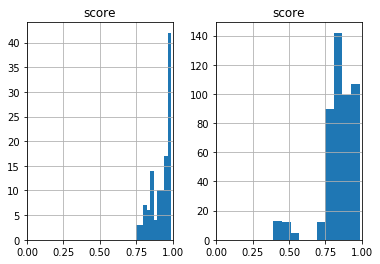

In [909]:
fig, axes = plt.subplots(ncols=2)
axes[0].set_title("postive score")
axes[0].set_xlim([0, 1])
test_df[test_df.spk.isin(enroll_spks)].hist(ax=axes[0])

axes[1].set_title("negative score")
axes[1].set_xlim([0, 1])
test_df[~test_df.spk.isin(enroll_spks)].hist(ax=axes[1])

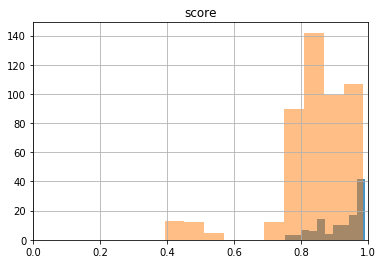

In [934]:
ax = plt.axes()
ax.set_xlim([0, 1])
test_df[test_df.spk.isin(enroll_spks)].hist(alpha=0.8, ax=ax)
test_df[~test_df.spk.isin(enroll_spks)].hist(alpha=0.5, ax=ax)
ax.legend()
plt.show()

### Confusion matrix

In [935]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 0  0  0  0  0  0  0 10  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 28  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0 26  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 29  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 29  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 21  0  8  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0 55  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 22  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 29  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0 10 19  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 23  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  0  0 23  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0 28  0  0  0  0  0  0  0  0]


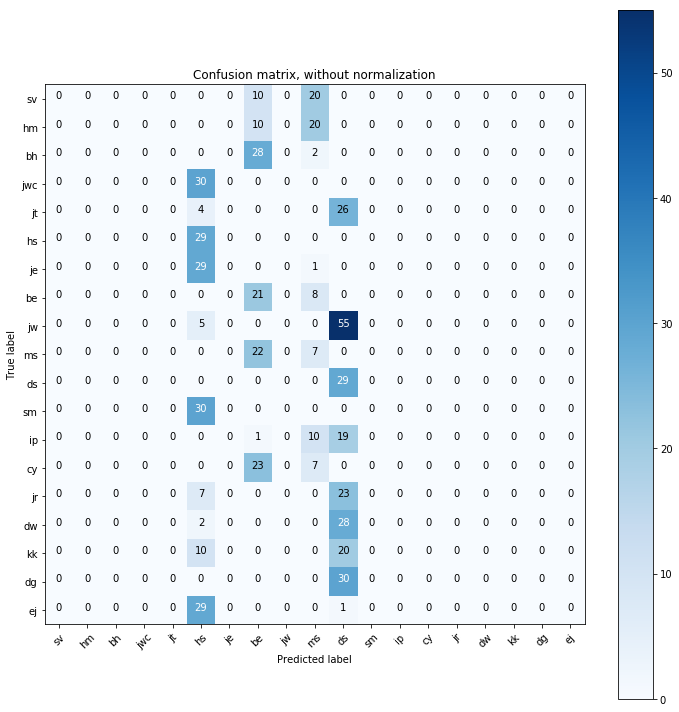

In [938]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(test_df.spk.tolist(), preds, labels=test_df.spk.unique().tolist())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=test_df.spk.unique().tolist(),
                      title='Confusion matrix, without normalization')

### Recording score results

In [944]:
result_df = pd.concat([test_df, pd.DataFrame.from_records(scores.round(4).tolist(), 
                                                          index=test_df.index, 
                                                          columns=test_sv_system.enrolled_dvectors.keys())], 
                      axis=1)

In [945]:
result_df['pred'] = preds

In [ ]:
result_df.drop(columns='score').to_csv("./ResNet34_v1_1/result.csv", float_format='%.3f', index=False)

In [ ]:
enrollment_df.to_csv("./ResNet34_v1_1/enrollment.csv", index=False)